In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d

In [2]:
# Datasets configuration
datasets = {
    "Severe_acute_respiratory_syndrome_coronavirus_2": {
        "base_path": "../data/Severe_acute_respiratory_syndrome_coronavirus_2/results",
        "max_position": 29903,
        "genes": [
            ("ORF1a", 266),
            ("ORF1b", 13483),
            ("S", 21563),
            ("E", 26245),
            ("M", 26523),
            ("N", 28274)
        ],
        "phastCons_path": "../data/Severe_acute_respiratory_syndrome_coronavirus_2/results/phastwebresult/phastConsscores.wig",
        "phyloP_path": "../data/Severe_acute_respiratory_syndrome_coronavirus_2/results/phastwebresult/phyloPscores.wig",
    },
    "Human_immunodeficiency_virus_1": {
        "base_path": "../data/Human_immunodeficiency_virus_1/results",
        "max_position": 8857,
        "genes": [
            ("gag", 336),
            ("gag-pol", 0),
            ("env", 5771)
        ],
        "phastCons_path": "../data/Human_immunodeficiency_virus_1/results/phastwebresult/phastConsscores.wig",
        "phyloP_path": "../data/Human_immunodeficiency_virus_1/results/phastwebresult/phyloPscores.wig",
    },
    "US28": {
        "base_path": "../data/Human_betaherpesvirus_5/US28/results",
        "max_position": None,  # Will be set later based on data
        "genes": [("US28", 0)],
        "phastCons_path": "../data/Human_betaherpesvirus_5/US28/results/phastwebresult/phastConsscores.wig",
        "phyloP_path": "../data/Human_betaherpesvirus_5/US28/results/phastwebresult/phyloPscores.wig",
    },
    "UL55": {
        "base_path": "../data/Human_betaherpesvirus_5/UL55/results",
        "max_position": None,  # Will be set later based on data
        "genes": [("UL55", 0)],
        "phastCons_path": "../data/Human_betaherpesvirus_5/UL55/results/phastwebresult/phastConsscores.wig",
        "phyloP_path": "../data/Human_betaherpesvirus_5/UL55/results/phastwebresult/phyloPscores.wig",
    },
    "UL73": {
        "base_path": "../data/Human_betaherpesvirus_5/UL73/results",
        "max_position": None,  # Will be set later based on data
        "genes": [("UL73", 0)],
        "phastCons_path": "../data/Human_betaherpesvirus_5/UL73/results/phastwebresult/phastConsscores.wig",
        "phyloP_path": "../data/Human_betaherpesvirus_5/UL73/results/phastwebresult/phyloPscores.wig",
    },
}

In [3]:
def load_data_from_json(filename):
    """
    Load data from a JSON file.

    Parameters:
        filename (str): Path to the JSON file.

    Returns:
        dict: Data loaded from the JSON file.

    Raises:
        FileNotFoundError: If the file does not exist.
        json.JSONDecodeError: If the file contains invalid JSON.
    """
    try:
        with open(filename, 'r') as file:
            return json.load(file)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from {filename}: {e}")
        raise
    except FileNotFoundError as e:
        print(f"File not found: {filename}")
        raise

In [4]:
def parse_wig(file_path):
    """
    Parses a WIG file and extracts positions and scores.
    
    Parameters:
        file_path (str): Path to the WIG file.
    
    Returns:
        tuple: Lists of positions and scores.
    """
    positions = []
    scores = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('fixedStep'):
                continue
            parts = line.strip().split()
            if len(parts) == 1:
                scores.append(float(parts[0]))
                positions.append(len(scores))
    return positions, scores

In [5]:
def scale_to_range(data, new_min, new_max):
    """
    Scales the input data to a specified range [new_min, new_max].

    Parameters:
    -----------
    data : array-like
        The input data to be scaled.
    new_min : float or int
        The minimum value of the target range.
    new_max : float or int
        The maximum value of the target range.

    Returns:
    --------
    scaled_data : numpy.ndarray
        The scaled data within [new_min, new_max].
    """
    old_min = np.min(data)
    old_max = np.max(data)
    
    if old_min == old_max:
        raise ValueError("All values in the input data are identical; scaling cannot be performed.")
    
    scaled_data = new_min + ((data - old_min) / (old_max - old_min)) * (new_max - new_min)
    
    return scaled_data

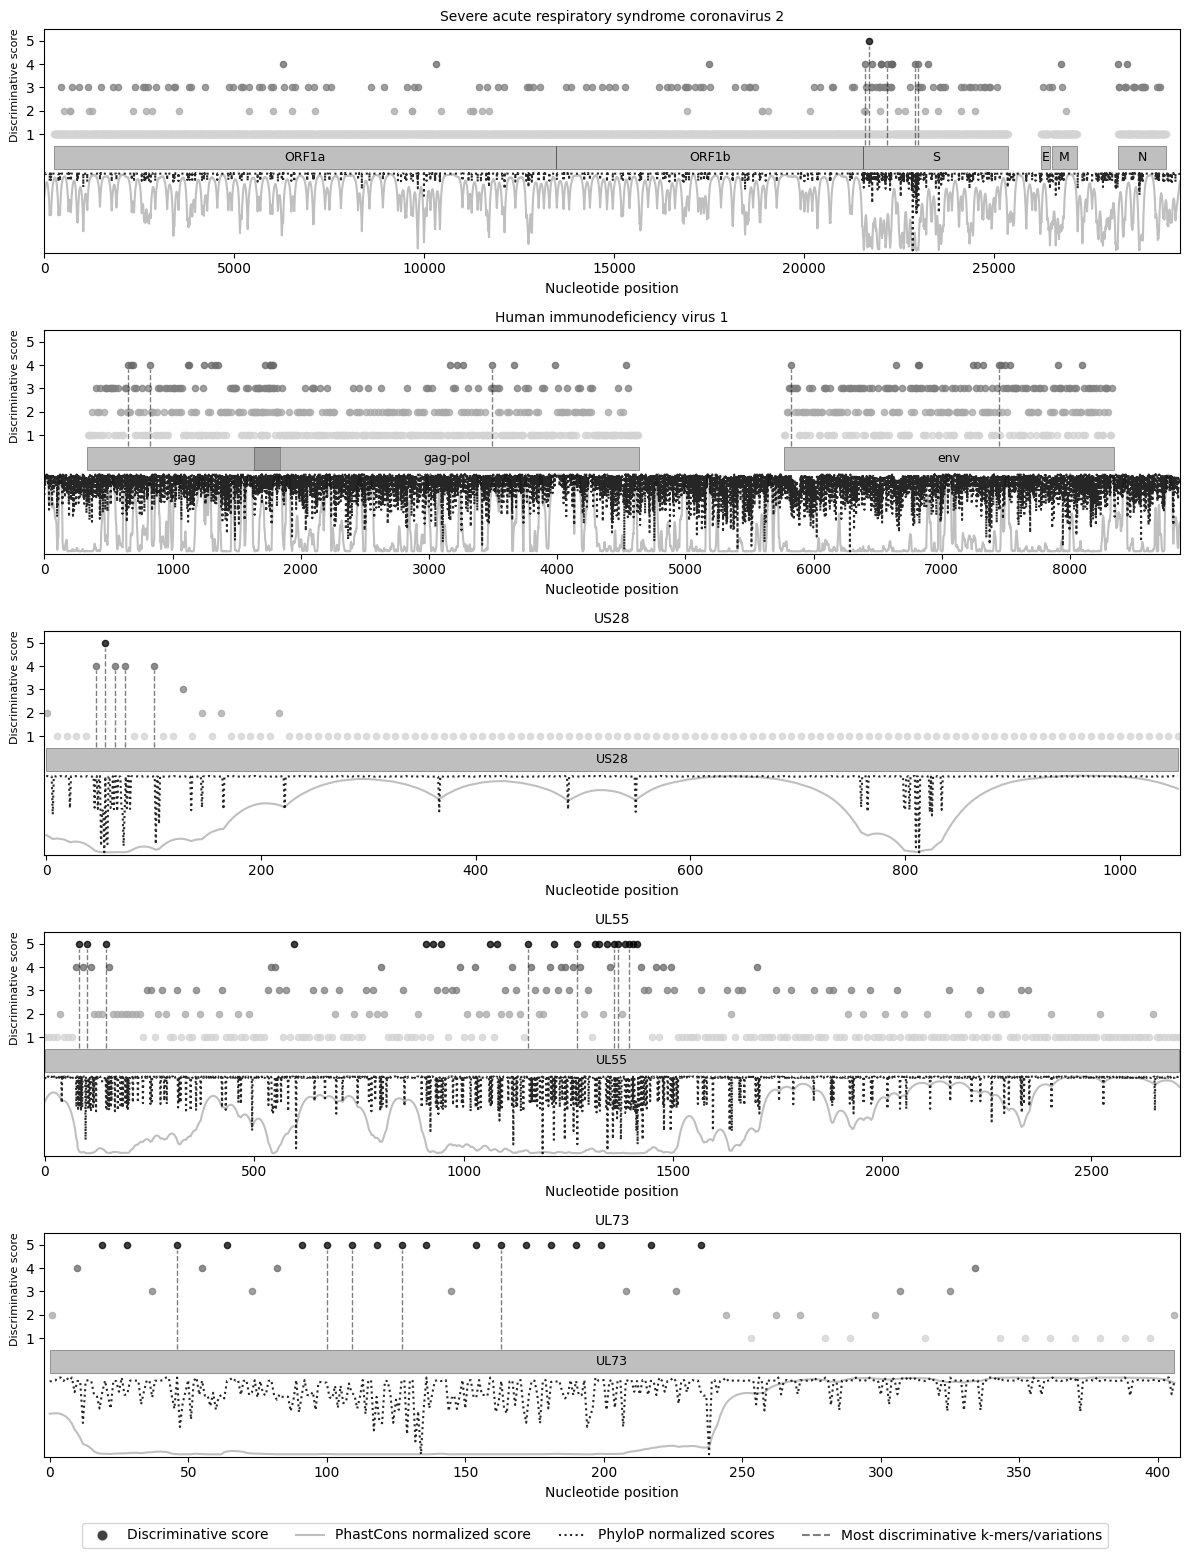

In [6]:
# Define colors
colors = ['lightgray', 'darkgrey', 'grey', 'dimgrey', 'black']

# Adjust figure size based on the number of datasets
fig, axs = plt.subplots(len(datasets), 1, figsize=(12, 3.2 * len(datasets)))

# Ensure axs is iterable
if len(datasets) == 1:
    axs = [axs]

for idx, (key, details) in enumerate(datasets.items()):
    ax = axs[idx]
    base_path = details["base_path"]
    genes = details["genes"]

    # Initialize max_position if not provided
    if details["max_position"] is None:
        details["max_position"] = 0

    # Plot scores for each gene
    for gene_name, gene_start in genes:
        scores = load_data_from_json(f"{base_path}/{gene_name}_categorized_scores.json")
        position_to_key_map = {int(k.split(',')[0][1:]): k for k in scores.keys()}
        positions = sorted(position_to_key_map.keys())
        f1_scores = [scores[position_to_key_map[pos]][3] for pos in positions]

        # Update max_position if necessary
        if details["max_position"] is None or max(positions) + gene_start > details["max_position"]:
            details["max_position"] = max(positions) + gene_start

        # Plot the scores
        for pos in positions:
            original_key = position_to_key_map[pos]
            f1_score = scores[original_key][3]
            ax.scatter(pos + gene_start, f1_score, color=colors[int(f1_score) - 1], s=20, alpha=0.75)

    # Load and interpolate conservation scores
    phastCons_positions, phastCons_scores = parse_wig(details["phastCons_path"])
    phyloP_positions, phyloP_scores = parse_wig(details["phyloP_path"])

    max_position = details["max_position"]
    x_range = np.arange(max_position + 1)

    phastCons_interpolator = interp1d(phastCons_positions, phastCons_scores, bounds_error=False, fill_value="extrapolate")
    phyloP_interpolator = interp1d(phyloP_positions, phyloP_scores, bounds_error=False, fill_value="extrapolate")

    interpolated_phastCons_scores = phastCons_interpolator(x_range)
    interpolated_phyloP_scores = phyloP_interpolator(x_range)

    scaled_phastCons_scores = scale_to_range(interpolated_phastCons_scores, -4, -0.7)
    scaled_phyloP_scores = scale_to_range(interpolated_phyloP_scores, -4, -0.7)

    # Add gene annotations and vertical lines for specific datasets
    if key == "Severe_acute_respiratory_syndrome_coronavirus_2":
        gene_regions = {
            "ORF1a": (266, 13483),
            "ORF1b": (13483, 21555),
            "S": (21563, 25384),
            "E": (26245, 26472),
            "M": (26523, 27191),
            "N": (28274, 29533),
        }
        for gene_name, (start, end) in gene_regions.items():
            ax.add_patch(patches.Rectangle((start, -0.5), end - start, 1, linewidth=0.5, edgecolor='k', facecolor='grey', alpha=0.5))
            ax.text((end - start) / 2 + start, 0, gene_name, verticalalignment='center', horizontalalignment='center', color='black', fontsize=9)

        vertical_lines = [21563 + offset for offset in [55, 640, 1360, 1450]]
        for line_pos in vertical_lines:
            ax.axvline(x=line_pos, ymin=0.48, ymax=0.825, color='black', linewidth=1, linestyle='--', alpha=0.5, zorder=10)
        ax.axvline(x=21563 + 154, ymin=0.48, ymax=0.925, color='black', linewidth=1, linestyle='--', alpha=0.5, zorder=10)


    elif key == "Human_immunodeficiency_virus_1":
        gene_regions = {
            "gag": (336, 1838),
            "gag-pol": (1637, 4642),
            "env": (5771, 8341),
        }
        for gene_name, (start, end) in gene_regions.items():
            ax.add_patch(patches.Rectangle((start, -0.5), end - start, 1, linewidth=0.5, edgecolor='k', facecolor='grey', alpha=0.5))
            ax.text((end - start) / 2 + start, 0, gene_name, verticalalignment='center', horizontalalignment='center', color='black', fontsize=9)

        vertical_lines = [55+5771, 1675+5771, 336+316, 487+336, 3158+336]
        for line_pos in vertical_lines:
            ax.axvline(x=line_pos, ymin=0.48, ymax=0.825, color='black', linewidth=1, linestyle='--', alpha=0.5, zorder=10)

    elif key in ["US28", "UL55", "UL73"]:
        gene_name = key
        start = 0
        end = max_position
        ax.add_patch(patches.Rectangle((start, -0.5), end, 1, linewidth=0.5, edgecolor='k', facecolor='grey', alpha=0.5))
        ax.text(end / 2, -0, gene_name, verticalalignment='center', horizontalalignment='center', color='black', fontsize=9)

        # Vertical lines specific to each gene
        vertical_lines_dict = {
            "US28": [(55, 0.925), (64, 0.825), (46, 0.825), (73, 0.825), (100, 0.825)],
            "UL55": [(82, 0.925), (100, 0.925), (145, 0.925), (1153, 0.925), (1270, 0.925), (1369, 0.925), (1360, 0.925), (1396, 0.925)],
            "UL73": [(46, 0.925), (100, 0.925), (109, 0.925), (163, 0.925), (127, 0.925)],
        }
        for line_pos in vertical_lines_dict.get(key, []):
            ax.axvline(x=line_pos[0], ymin=0.48, ymax=line_pos[1], color='black', linewidth=1, linestyle='--', alpha=0.5, zorder=10)

    # Plot interpolated conservation scores
    ax.plot(x_range, scaled_phastCons_scores, label='PhastCons Scores', linestyle='-', color='grey', alpha=0.5)
    ax.plot(x_range, scaled_phyloP_scores, label='PhyloP Scores', linestyle=':', color='black', alpha=0.85)

    # Set plot parameters
    ax.set_title(key.replace('_', ' '), fontsize=10)
    ax.set_xlabel('Nucleotide position')
    ax.set_ylabel(" " * 32 + 'Discriminative score', fontsize=8)
    ax.set_xlim(-2, max_position + 2)
    ax.set_ylim(-4.1, 5.5)
    ax.set_yticks([1, 2, 3, 4, 5])

# Add a legend with custom lines
custom_lines = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8, alpha=0.75),
    Line2D([0], [0], linestyle='-', color='grey', alpha=0.5),
    Line2D([0], [0], linestyle=':', color='black', alpha=0.85),
    Line2D([0], [0], linestyle='--', color='black', alpha=0.5),
]
fig.legend(
    custom_lines,
    ["Discriminative score", "PhastCons normalized score", "PhyloP normalized scores", "Most discriminative k-mers/variations"],
    loc='lower center',
    bbox_to_anchor=(0.5, 0.025),
    ncol=4
)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('f1_rms_rank_weighted_discriminative_score_figure.pdf', dpi=300)
plt.show()